# Solution Template

Use this notebook as a guide to implement your solution. Keep in mind that some cells should remain as they are so that you code works properly, for instance, the following cell in which the required libraries are imported.

In [50]:
import pandas as pd
import numpy as np
import networkx as nx # for drawing graphs
import matplotlib.pyplot as plt # for drawing graphs
from pybbn.graph.dag import Bbn # for creating Bayesian Belief Networks (BBN)
from pybbn.graph.edge import Edge, EdgeType
from pybbn.graph.jointree import EvidenceBuilder
from pybbn.graph.node import BbnNode
from pybbn.graph.variable import Variable
from pybbn.pptc.inferencecontroller import InferenceController

Just run the next cell to load the data.

In [51]:
diabetes = pd.read_csv('diabetes-dataset.csv')
diabetes.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,2,138,62,35,0,33.6,0.127,47,1
1,0,84,82,31,125,38.2,0.233,23,0
2,0,145,0,0,0,44.2,0.630,31,1
3,0,135,68,42,250,42.3,0.365,24,1
4,1,139,62,41,480,40.7,0.536,21,0


Create a new column called `Overweight` in which a person whose `BMI` is above 25 will be tagged as a one, and zero otherwise.

In [52]:
diabetes['Overweight'] = (diabetes['BMI'] > 25).astype(int)

You are to code the next function, which discretize all the variables of the dataset, except `Outcome` and `Overweight`. Remember that you will discretize with respect to the quantiles of each variables: if a variable value is less than Q1, then said value is replaced by a **zero**; if the given value is greater or equal than Q1 but less than Q2, then the value should be replaced by a **one**; if the variable value is greater or equal than Q2 but less than Q3, then the value should be replaced by a **two**; finally, if a variable value is greater than Q3, it should be assigned the value **three**. 

In [53]:
def discretize(df):
    
    """
    This function receives a dataframe as input and returns a dataframe in which each variable has been 
    discretized. 
    """
    
    "INSERT YOUR CODE HERE"
    
    discretized_df = df.copy()
    cols = [col for col in df.columns if col not in ['Outcome', 'Overweight']]

    for col in cols:
        q1, q2, q3 = df[col].quantile([0.25, 0.50, 0.75])
        discretized_df[col] = df[col].apply(
            lambda x: 0 if x < q1 else 1 if x < q2 else 2 if x < q3 else 3
        )

    return discretized_df

In [54]:
discrete_df = discretize(diabetes)
discrete_df

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome,Overweight
0,1,2,0,3,1,2,0,3,1,1
1,0,0,3,2,2,3,0,0,0,1
2,0,3,0,1,1,3,3,2,1,1
3,0,2,1,3,3,3,1,1,1,1
4,1,2,0,3,3,3,2,0,0,1
...,...,...,...,...,...,...,...,...,...,...
1995,1,0,1,2,2,1,1,2,0,1
1996,3,3,2,3,3,2,3,2,1,1
1997,3,0,2,1,1,1,2,3,0,1
1998,0,2,3,3,3,3,1,1,1,1


In the following cel you are to create two dictionaries: `graph` will store the topology of the Bayesian network, so each element is associated to a list that contains the names of the parents of said element; `values` stores the values that each variable of the network takes, which are the discrete values that were computed above.

In [55]:
graph = {'Overweight': [],
         'DiabetesPedigreeFunction': [],
         'Age': [],
         'Pregnancies': [],
         'SkinThickness' : ['Overweight'],
         'BMI': ['Overweight'],
         'Outcome': ['Overweight','DiabetesPedigreeFunction','Age','Pregnancies'],
         'BloodPressure': ['Overweight','Outcome'],
         'Insulin': ['Outcome'],
         'Glucose': ['Outcome']}

values = {'Overweight': [0,1],
          'DiabetesPedigreeFunction': [0,1,2,3],
          'Age': [0,1,2,3],
          'Pregnancies': [0,1,2,3],
          'SkinThickness' : [0,1,2,3],
          'BMI': [0,1,2,3],
          'Outcome': [0,1],
          'BloodPressure': [0,1,2,3],
          'Insulin': [0,1,2,3],
          'Glucose': [0,1,2,3]}

The next function obtains the probabilities of a given node. This function will be used later to create a dictionary in which each element contains a node and its list of probabilities.

In [56]:
def probabilities(df, node):

    """
    This function computes the probabilities of a given node. It should receive a dataframe and the dictionaries
    graph and values. The probabilities shoud be stored in a list and returned in probabilities_list.
    """

    probabilities_list = []

    "INSERT YOUR CODE HERE"

    parents = graph[node]
    node_values = values[node]

    if len(parents) == 0:
        total = len(df)
        for node_value in node_values:
            p = len(df[df[node] == node_value]) / total
            probabilities_list.append(p)

    else:
        parent_values = [values[parent] for parent in parents]
        from itertools import product

        for pair in product(*parent_values):
            subset = df.copy()
            for i, parent in enumerate(parents):
                subset = subset[subset[parent] == pair[i]]

            total = len(subset)

            if total > 0:
                for node_value in node_values:
                    p = len(subset[subset[node] == node_value]) / total
                    probabilities_list.append(p)
            else:
                for node_value in node_values:
                    probabilities_list.append(1/len(node_values))

    return probabilities_list

The following function must create a dictionary in which item is a node and its corresponding list of probabilities

In [57]:
def tables(df):

    """
    This function returns a dictionary in which each element is a node and its list of probabilities. It should
    call the above function, probabilities, which computes the probabilities of a given node.
    """

    probabilities_tables = {}

    "INSERT YOUR CODE HERE"

    for node in graph:
        probabilities_tables[node] = probabilities(df, node)

    return probabilities_tables

Create the nodes of the network in this cell. For each line, replace `"node index"` and the empty list by the proper variable name and variable values, respectively.

In [58]:
table = tables(discrete_df)

overweight_probabilities = table['Overweight']
diabetes_pedigree_function_probabilities = table['DiabetesPedigreeFunction']
age_probabilities = table['Age']
pregnancies_probabilities = table['Pregnancies']
skin_thickness_probabilities = table['SkinThickness']
bmi_probabilities = table['BMI']
outcome_probabilities = table['Outcome']
blood_pressure_probabilities = table['BloodPressure']
insulin_probabilities = table['Insulin']
glucose_probabilities = table['Glucose']

In [59]:
overweight = BbnNode(Variable(0, 'Overweight', ['0','1']), overweight_probabilities)
diabetes_pedigree_function = BbnNode(Variable(1, 'DiabetesPedigreeFunction', ['0','1','2','3']), diabetes_pedigree_function_probabilities)
age = BbnNode(Variable(2, 'Age', ['0','1','2','3']), age_probabilities)
pregnancies = BbnNode(Variable(3, 'Pregnancies', ['0','1','2','3']), pregnancies_probabilities)
skin_thickness = BbnNode(Variable(4, 'SkinThickness', ['0','1','2','3']), skin_thickness_probabilities)
bmi = BbnNode(Variable(5, 'BMI', ['0','1','2','3']), bmi_probabilities)
outcome = BbnNode(Variable(6, 'Outcome', ['0','1']), outcome_probabilities)
blood_pressure = BbnNode(Variable(7, 'BloodPressure', ['0','1','2','3']), blood_pressure_probabilities)
insulin = BbnNode(Variable(8, 'Insulin', ['0','1','2','3']), insulin_probabilities)
glucose = BbnNode(Variable(9, 'Glucose', ['0','1','2','3']), glucose_probabilities)

Implement your graph in the following cell. Add as many nodes and edges as necessary. Replace the strings by the proper variables.

In [60]:
bbn = Bbn() \
    .add_node(overweight) \
    .add_node(diabetes_pedigree_function) \
    .add_node(age) \
    .add_node(pregnancies) \
    .add_node(skin_thickness) \
    .add_node(bmi) \
    .add_node(outcome) \
    .add_node(blood_pressure) \
    .add_node(insulin) \
    .add_node(glucose) \
    .add_edge(Edge(overweight, skin_thickness, EdgeType.DIRECTED)) \
    .add_edge(Edge(overweight, bmi, EdgeType.DIRECTED)) \
    .add_edge(Edge(overweight, outcome, EdgeType.DIRECTED)) \
    .add_edge(Edge(overweight, blood_pressure, EdgeType.DIRECTED)) \
    .add_edge(Edge(diabetes_pedigree_function, outcome, EdgeType.DIRECTED)) \
    .add_edge(Edge(age, outcome, EdgeType.DIRECTED)) \
    .add_edge(Edge(pregnancies, outcome, EdgeType.DIRECTED)) \
    .add_edge(Edge(outcome, blood_pressure, EdgeType.DIRECTED)) \
    .add_edge(Edge(outcome, insulin, EdgeType.DIRECTED)) \
    .add_edge(Edge(outcome, glucose, EdgeType.DIRECTED))

Do not forget to run this cell and do not modify it, inferences depend on it.

In [61]:
# Convert the BBN to a join tree. Do not modify this cell.

join_tree = InferenceController.apply(bbn)

The following cell is very useful for visualizing your Bayesian network. It is very recommended that you make the necessary changes and run it to verify that your network was implementented correctly.

{0: 'Overweight', 1: 'DiabetesPedigreeFunction', 2: 'Age', 3: 'Pregnancies', 4: 'SkinThickness', 5: 'BMI', 6: 'Outcome', 7: 'BloodPressure', 8: 'Insulin', 9: 'Glucose'}


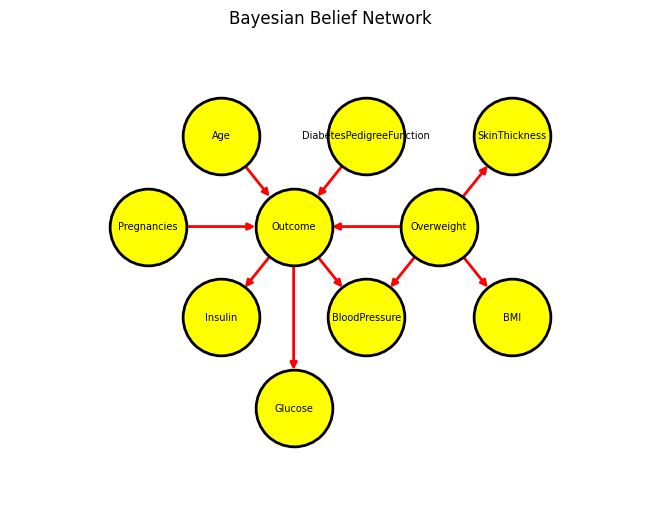

In [74]:
# Set node positions.

pos = {
    0: (16, 8),
    1: (12, 12),
    2: (4, 12),
    3: (0, 8),
    4: (20, 12),
    5: (20, 4),
    6: (8, 8),
    7: (12, 4),
    8: (4, 4),
    9: (8, 0)
}
print(d)

# Set options for graph looks. You might have to adjust these parameters.

options = {"font_size" : 7, "node_size" : 3050, "node_color" : "yellow",
           "edgecolors" : "black", "edge_color" : "red", "linewidths" : 2,
           "width": 2}

# Generate graph.

n, d = bbn.to_nx_graph()
nx.draw(n, with_labels=True, labels=d, pos=pos, **options)

# Update margins and print the graph.

ax = plt.gca()
ax.margins(0.3)
plt.axis("off")
plt.title("Bayesian Belief Network")
plt.show()

The goal of `print_probs` is to print out the probability distributions of all the nodes of the network. You can modify this code to print only the distributions of certain nodes if you find that helpful.

In [63]:
# Define a function for printing marginal probabilities.

def print_probs():
    for node in join_tree.get_bbn_nodes():
        potential = join_tree.get_bbn_potential(node)
        print("Node:", node)
        print("Values:")
        print(potential)
        print('----------------')

# Use the above function to print marginal probabilities.

print_probs()

Node: 0|Overweight|0,1
Values:
0=0|0.15300
0=1|0.84700
----------------
Node: 4|SkinThickness|0,1,2,3
Values:
4=0|0.00000
4=1|0.48100
4=2|0.22900
4=3|0.29000
----------------
Node: 5|BMI|0,1,2,3
Values:
5=0|0.25000
5=1|0.24900
5=2|0.25000
5=3|0.25100
----------------
Node: 6|Outcome|0,1
Values:
6=0|0.63567
6=1|0.36433
----------------
Node: 8|Insulin|0,1,2,3
Values:
8=0|0.00000
8=1|0.50021
8=2|0.24114
8=3|0.25865
----------------
Node: 9|Glucose|0,1,2,3
Values:
9=0|0.22964
9=1|0.25234
9=2|0.25572
9=3|0.26230
----------------
Node: 7|BloodPressure|0,1,2,3
Values:
7=0|0.24858
7=1|0.23055
7=2|0.25915
7=3|0.26172
----------------
Node: 1|DiabetesPedigreeFunction|0,1,2,3
Values:
1=0|0.24850
1=1|0.25100
1=2|0.24950
1=3|0.25100
----------------
Node: 2|Age|0,1,2,3
Values:
2=0|0.23050
2=1|0.25950
2=2|0.24700
2=3|0.26300
----------------
Node: 3|Pregnancies|0,1,2,3
Values:
3=0|0.15050
3=1|0.32000
3=2|0.26350
3=3|0.26600
----------------


The function `evidence` helps tyou to create evidence that will be used for making inferences. Do not modify this cell, please.

In [64]:
# To add evidence of events that happened so probability distribution can be recalculated.

def evidence(ev, nod, val, like):
    ev = EvidenceBuilder() \
    .with_node(join_tree.get_bbn_node_by_name(nod)) \
    .with_evidence(val, like) \
    .build()
    join_tree.set_observation(ev)

Now you are ready to add evidence and print out the new distributions of your network. 

In [65]:
# Use above function to add evidence.

# evidence('ev1', 'node name', 'value', 1)

# Print marginal probabilities.

# print_probs()

If you need to reset the Bayesian network, rerun this line of code or rerun the above cell twice.

In [66]:
# join_tree = InferenceController.apply(bbn)

Experiment 1

In [67]:
evidence('ev1', 'Overweight', '1', 1)
evidence('ev2', 'Pregnancies', '3', 1)
evidence('ev3', 'Age', '3', 1)
evidence('ev4', 'DiabetesPedigreeFunction', '3', 1)
print_probs()

Node: 0|Overweight|0,1
Values:
0=0|0.00000
0=1|1.00000
----------------
Node: 4|SkinThickness|0,1,2,3
Values:
4=0|0.00000
4=1|0.40791
4=2|0.25620
4=3|0.33589
----------------
Node: 5|BMI|0,1,2,3
Values:
5=0|0.11452
5=1|0.29398
5=2|0.29516
5=3|0.29634
----------------
Node: 6|Outcome|0,1
Values:
6=0|0.19481
6=1|0.80519
----------------
Node: 8|Insulin|0,1,2,3
Values:
8=0|0.00000
8=1|0.51426
8=2|0.15501
8=3|0.33073
----------------
Node: 9|Glucose|0,1,2,3
Values:
9=0|0.11398
9=1|0.18988
9=2|0.27001
9=3|0.42614
----------------
Node: 7|BloodPressure|0,1,2,3
Values:
7=0|0.18280
7=1|0.23613
7=2|0.25683
7=3|0.32424
----------------
Node: 1|DiabetesPedigreeFunction|0,1,2,3
Values:
1=0|0.00000
1=1|0.00000
1=2|0.00000
1=3|1.00000
----------------
Node: 2|Age|0,1,2,3
Values:
2=0|0.00000
2=1|0.00000
2=2|0.00000
2=3|1.00000
----------------
Node: 3|Pregnancies|0,1,2,3
Values:
3=0|0.00000
3=1|0.00000
3=2|0.00000
3=3|1.00000
----------------


In [68]:
join_tree = InferenceController.apply(bbn)

Experiment 2

In [69]:
evidence('ev1', 'Overweight', '0', 1)
evidence('ev2', 'Pregnancies', '0', 1)
evidence('ev3', 'Age', '0', 1)
evidence('ev4', 'DiabetesPedigreeFunction', '0', 1)
print_probs()

Node: 0|Overweight|0,1
Values:
0=0|1.00000
0=1|0.00000
----------------
Node: 4|SkinThickness|0,1,2,3
Values:
4=0|0.00000
4=1|0.88562
4=2|0.07843
4=3|0.03595
----------------
Node: 5|BMI|0,1,2,3
Values:
5=0|1.00000
5=1|0.00000
5=2|0.00000
5=3|0.00000
----------------
Node: 6|Outcome|0,1
Values:
6=0|1.00000
6=1|0.00000
----------------
Node: 8|Insulin|0,1,2,3
Values:
8=0|0.00000
8=1|0.48860
8=2|0.31231
8=3|0.19909
----------------
Node: 9|Glucose|0,1,2,3
Values:
9=0|0.32523
9=1|0.30395
9=2|0.24392
9=3|0.12690
----------------
Node: 7|BloodPressure|0,1,2,3
Values:
7=0|0.44561
7=1|0.24561
7=2|0.18246
7=3|0.12632
----------------
Node: 1|DiabetesPedigreeFunction|0,1,2,3
Values:
1=0|1.00000
1=1|0.00000
1=2|0.00000
1=3|0.00000
----------------
Node: 2|Age|0,1,2,3
Values:
2=0|1.00000
2=1|0.00000
2=2|0.00000
2=3|0.00000
----------------
Node: 3|Pregnancies|0,1,2,3
Values:
3=0|1.00000
3=1|0.00000
3=2|0.00000
3=3|0.00000
----------------
